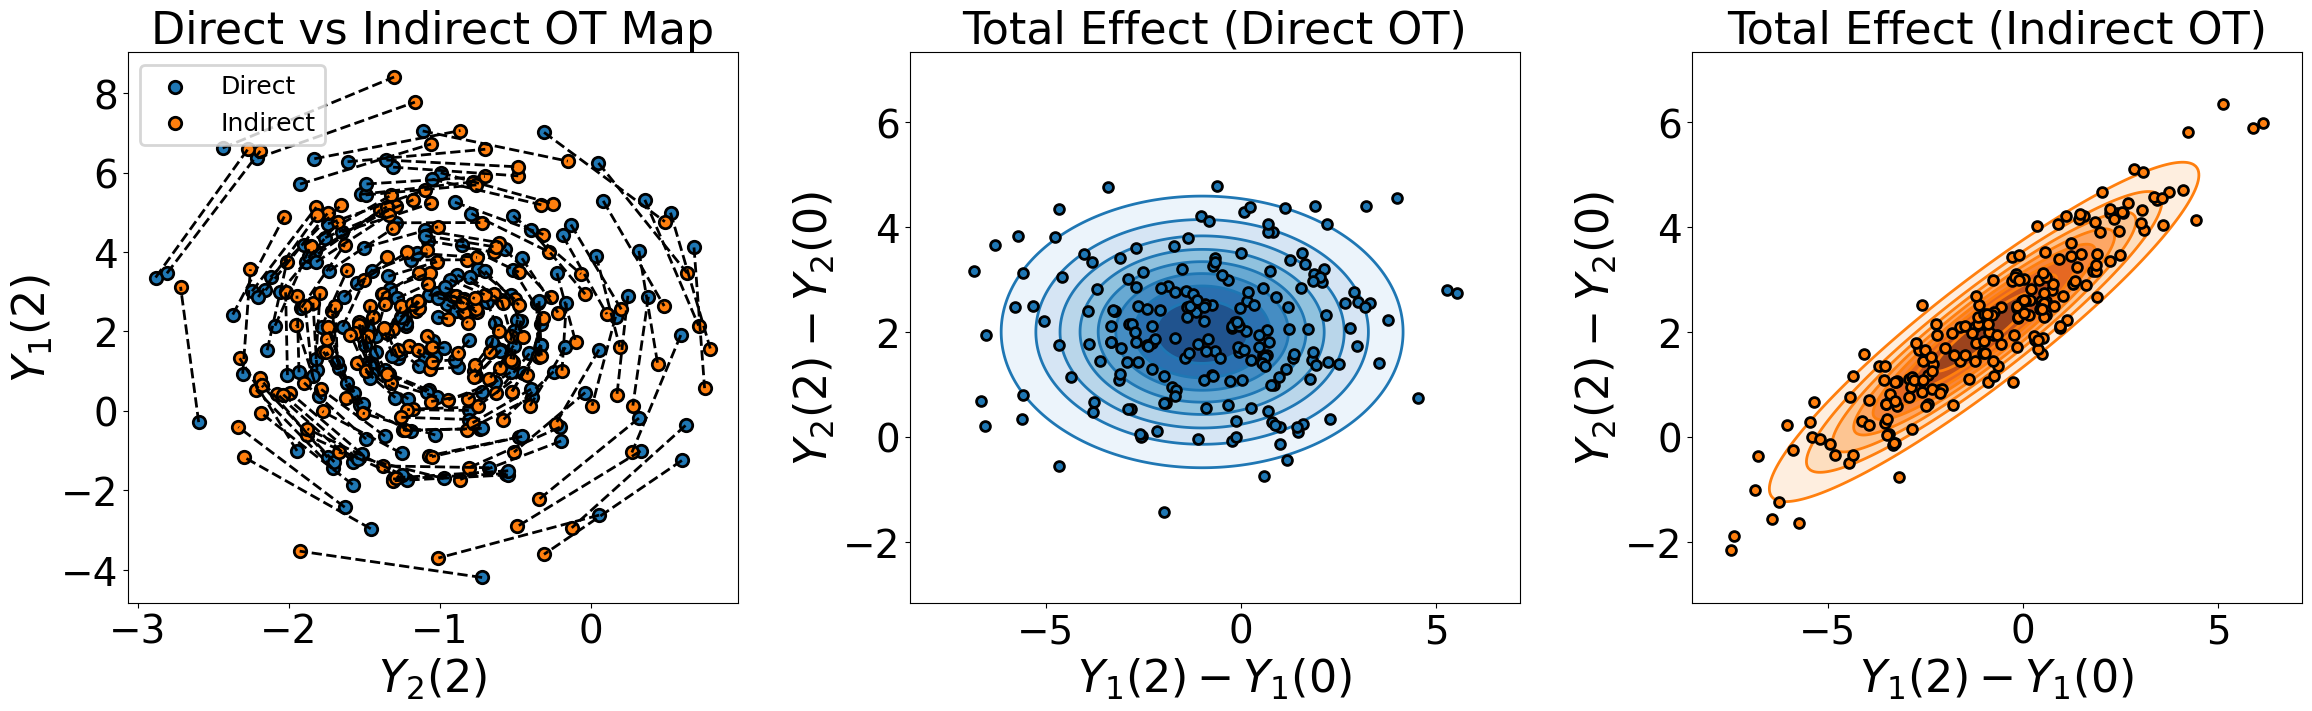

In [3]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# Increase overall font sizes and line widths
plt.rcParams.update({
    'font.size': 36,
    'axes.titlesize': 32,
    'axes.labelsize': 32,
    'xtick.labelsize': 28,
    'ytick.labelsize': 28,
    'legend.fontsize': 18,
    'lines.linewidth': 2,
    'patch.linewidth': 2
})

# Fix random seed for reproducibility
np.random.seed(0)

# 1) Define three 2D Gaussians (means and covariances)
m0 = np.array([0.0, 0.0])
m1 = np.array([1.0, 1.0])
m2 = np.array([-1.0, 2.0])
S0 = np.array([[10.0, 0.0],
               [0.0, 1.0]])
S1 = np.array([[1.0, -0.9],
               [-0.9, 1.0]])
S2 = np.array([[0.5, 0.0],
               [0.0, 5.0]])

# Draw samples from P0
N = 200
X0 = np.random.multivariate_normal(m0, S0, size=N)

# Compute Brenier-map matrices
def compute_A(S, S_prime):
    sqrtS     = scipy.linalg.sqrtm(S)
    inv_sqrtS = scipy.linalg.inv(sqrtS)
    M         = sqrtS @ S_prime @ sqrtS
    A         = inv_sqrtS @ scipy.linalg.sqrtm(M) @ inv_sqrtS
    return A.real

A01 = compute_A(S0, S1)
A02 = compute_A(S0, S2)
A12 = compute_A(S1, S2)

# Affine Brenier transport
def T(x, A, m, m_prime):
    return (m_prime + (A @ (x - m).T).T)

# Transform and compute effects Δ = Y(2) - X0
X02_direct   = T(X0, A02, m0, m2)
X02_indirect = T(T(X0, A01, m0, m1), A12, m1, m2)
Delta_dir = X02_direct - X0
Delta_ind = X02_indirect - X0

# Prepare grid for contour shading
x_min = min(Delta_dir[:,0].min(), Delta_ind[:,0].min()) - 1
x_max = max(Delta_dir[:,0].max(), Delta_ind[:,0].max()) + 1
y_min = min(Delta_dir[:,1].min(), Delta_ind[:,1].min()) - 1
y_max = max(Delta_dir[:,1].max(), Delta_ind[:,1].max()) + 1

x = np.linspace(x_min, x_max, 300)
y = np.linspace(y_min, y_max, 300)
Xg, Yg = np.meshgrid(x, y)
pos = np.dstack([Xg, Yg])

# Multivariate normal PDF for Δ
def mvn_pdf(pos, mu, Sigma):
    det = np.linalg.det(Sigma)
    inv = np.linalg.inv(Sigma)
    norm = 1 / (2 * np.pi * np.sqrt(det))
    diff = pos - mu
    return norm * np.exp(-0.5 * np.einsum('...i,ij,...j', diff, inv, diff))

# Compute effect distribution parameters
mu = m2 - m0
Sigma_dir = (A02 - np.eye(2)) @ S0 @ (A02 - np.eye(2)).T
Sigma_ind = (A12 @ A01 - np.eye(2)) @ S0 @ (A12 @ A01 - np.eye(2)).T

# Compute densities and levels
Z_dir = mvn_pdf(pos, mu, Sigma_dir)
Z_ind = mvn_pdf(pos, mu, Sigma_ind)
levels_dir = np.linspace(Z_dir.min(), Z_dir.max(), 10)
levels_ind = np.linspace(Z_ind.min(), Z_ind.max(), 10)

# Create side-by-side subplots with larger figure size
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Direct vs Indirect Brenier transport
ax = axes[0]
ax.scatter(X02_direct[:,0], X02_direct[:,1], color='C0', label='Direct', s=80, edgecolor = "black")
ax.scatter(X02_indirect[:,0], X02_indirect[:,1], color='C1', label='Indirect', s=80, edgecolor = "black")
for i in range(N):
    ax.plot([X02_direct[i,0], X02_indirect[i,0]],
            [X02_direct[i,1], X02_indirect[i,1]],
            color='black', linestyle='--', linewidth=2)
ax.set_title(r'Direct vs Indirect OT Map')
ax.set_xlabel(r"$Y_2(2)$")
ax.set_ylabel(r"$Y_1(2)$")
ax.legend()
#ax.set_aspect('equal')

# Plot 2: Direct effect
ax = axes[1]
contf1 = ax.contourf(Xg, Yg, Z_dir, levels=levels_dir[1:], extend='neither',
                     alpha=0.9, cmap='Blues')
ax.contour(Xg, Yg, Z_dir, levels=levels_dir, colors='C0', linewidths=2)
ax.scatter(Delta_dir[:,0], Delta_dir[:,1], s=50, color='C0', edgecolor='black', zorder = 100)
ax.set_title('Total Effect (Direct OT)')
ax.set_xlabel(r'$Y_1(2) - Y_1(0)$'); ax.set_ylabel(r'$Y_2(2) - Y_2(0)$')
#ax.set_aspect('equal')

# Plot 3: Indirect effect
ax = axes[2]
contf2 = ax.contourf(Xg, Yg, Z_ind, levels=levels_ind[1:], extend='neither',
                     alpha=0.9, cmap='Oranges')
ax.contour(Xg, Yg, Z_ind, levels=levels_ind, colors='C1', linewidths=2)
ax.scatter(Delta_ind[:,0], Delta_ind[:,1], s=50, color='C1', edgecolor='black', zorder = 100)
ax.set_title('Total Effect (Indirect OT)')
ax.set_xlabel(r'$Y_1(2) - Y_1(0)$'); ax.set_ylabel(r'$Y_2(2) - Y_2(0)$')
#ax.set_aspect('equal')

plt.tight_layout()
plt.savefig("brenierinconsistencylim.png", bbox_inches = "tight")
plt.show()